<a href="https://colab.research.google.com/github/violetaElCactus/predictGames/blob/main/Metacritic_Inteligencia_artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar librerías

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

print("Tensorflow: " + tf.__version__)

Tensorflow: 2.5.0


#Importar los datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#data_juegos = pd.read_csv("drive/My Drive/Colab Notebooks/metacritic_game_info.csv")
data_comentarios = pd.read_csv("drive/My Drive/Colab Notebooks/metacritic_game_user_comments.csv")

Mounted at /content/drive


##Información juegos

In [3]:
#data_juegos.head(10)

##Información comentarios

In [4]:
data_comentarios.head(10)

,Unnamed: 0,Title,Platform,Userscore,Comment,Username
0,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus
1,1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin
2,2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody
3,3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman
4,4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA
5,5,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I think it's funny that you have Zelda haters ...,joei1382
6,6,The Legend of Zelda: Ocarina of Time,Nintendo64,9,I played A Link To The Past so many times in m...,Corvix
7,7,The Legend of Zelda: Ocarina of Time,Nintendo64,10,The Legend of Zelda: Ocarina of Time is withou...,pittsburghboy91
8,8,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"This review contains spoilers, cli...",Nosidda89
9,9,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm not kidding when I say that this is the on...,Regeneration13


                      0     1     2     3   ...     7      8      9       10
Number of reviews  20120  7318  5983  7118  ...  17052  30271  53489  112531

[1 rows x 11 columns]
Mean score:  7.6183081381632


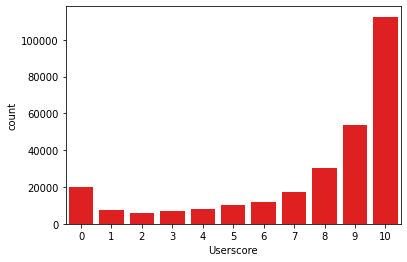

In [5]:
import seaborn as sns

temp=pd.DataFrame(data_comentarios.Userscore.value_counts())
temp.sort_index(inplace=True)
temp.columns=['Number of reviews']
clrs=['red' if (x > 5000) else 'lightcoral' for x in temp['Number of reviews'] ] #highlight bars
sns.countplot(data=data_comentarios,x='Userscore',palette=clrs) 
print(temp.T)
print('Mean score: ', data_comentarios.Userscore.mean())

In [6]:
data_comentarios = data_comentarios[data_comentarios['Comment'].str.len() > 280] #Comentario más largo que un Tweet.


In [7]:
data_comentarios = data_comentarios[data_comentarios['Comment'].map(lambda x: x.isascii())]


In [8]:
data_comentarios["Comment"] = data_comentarios["Comment"].str.lower()


In [9]:
df1 = data_comentarios.iloc[:60000]

In [10]:
len(df1)

60000

In [11]:
df1.drop(['Unnamed: 0','Username','Title','Platform'], axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
df1.head(10)


,Userscore,Comment
2,10,anyone who gives the masterpiece below a 7 or ...
3,10,i'm one of those people who think that this is...
4,10,this game is the highest rated game on metacr...
5,10,i think it's funny that you have zelda haters ...
7,10,the legend of zelda: ocarina of time is withou...
8,10,"this review contains spoilers, cli..."
9,10,i'm not kidding when i say that this is the on...
10,10,"essentially one of the best games of all time,..."
11,10,this is the perfect game ! no doubt. the gamep...
16,10,"amazing game in every aspect, i just want to ..."


#Dividir los datos en entrenamiento, validación y prueba




In [13]:
train, validate, test = np.split(df1.sample(frac=1), [int(.7*len(df1)), int(.8*len(df1))])


In [14]:
train_comments = train['Comment']
train_labels = train['Userscore']
validate_comments = validate['Comment']
validate_labels = validate['Userscore']
test_comments = test['Comment']
test_labels = test['Userscore']

#Tokenizer


In [15]:
import keras
from keras.preprocessing.text import Tokenizer


In [16]:
vocab_size = 12000
max_seq_length = 580
tokenize = Tokenizer(num_words=vocab_size, char_level=False)
tokenize.fit_on_texts(train_comments)

In [18]:
matrix = tokenize.texts_to_matrix(train_comments, mode = 'binary')
#sequential = tokenize.texts_to_sequences(train_comments)
#sequential = keras.preprocessing.sequence.pad_sequences(
#        sequential, maxlen=max_seq_length, padding="post")"""

In [20]:
matrixVal = tokenize.texts_to_matrix(validate_comments, mode = 'binary')
#sequentialVal = tokenize.texts_to_sequences(train_comments)
#sequentialVal = keras.preprocessing.sequence.pad_sequences(
#        sequentialVal, maxlen=max_seq_length, padding="post")"""

In [21]:
matrixTest = tokenize.texts_to_matrix(test_comments, mode = 'binary')
#sequentialTest = tokenize.texts_to_sequences(train_comments)
#sequentialTest = keras.preprocessing.sequence.pad_sequences(
#        sequentialTest, maxlen=max_seq_length, padding="post")"""

#Modelo Combinado


In [26]:
"""from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import regularizers"""

In [27]:
"""x = Dense(16, activation="relu")(matrix)
x = Dense(16, activation="relu")(x)
x = Model(inputs=matrix, outputs=x)
y = Dense(16, activation="relu")(sequential)
y = Dense(16, activation="relu")(y)
y = Model(inputs=sequential, outputs=y)"""

NameError: ignored

In [ ]:
"combined = concatenate([x.output, y.output])"


#Modelo

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import regularizers

In [43]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience= 3, verbose= 1)

In [44]:
y_train_vec = to_categorical(train_labels, num_classes=11)
y_validate_vec = to_categorical(validate_labels,num_classes=11)
y_test_vec = to_categorical(test_labels,num_classes=11)

In [45]:
modelMtx = models.Sequential()
modelMtx.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(12000,)))
modelMtx.add(layers.Dense(16,activation='relu'))
modelMtx.add(layers.Dense(16,activation='relu'))
modelMtx.add(Dropout(0.5))
modelMtx.add(layers.Dense(11, activation='softmax'))
modelMtx.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
history = modelMtx.fit(matrix, y_train_vec, epochs=20, validation_data=(matrixVal,y_validate_vec), callbacks= [es])

Epoch 1/20
1313/1313 [==============================] - 9s 6ms/step - loss: 1.5453 - accuracy: 0.4790 - val_loss: 1.3486 - val_accuracy: 0.5265
Epoch 2/20
1313/1313 [==============================] - 8s 6ms/step - loss: 1.3866 - accuracy: 0.5229 - val_loss: 1.3363 - val_accuracy: 0.5327
Epoch 3/20
1313/1313 [==============================] - 8s 6ms/step - loss: 1.3497 - accuracy: 0.5412 - val_loss: 1.3567 - val_accuracy: 0.5440
Epoch 4/20
1313/1313 [==============================] - 8s 6ms/step - loss: 1.3318 - accuracy: 0.5457 - val_loss: 1.3718 - val_accuracy: 0.5362
Epoch 5/20
1313/1313 [==============================] - 8s 6ms/step - loss: 1.3207 - accuracy: 0.5503 - val_loss: 1.3816 - val_accuracy: 0.5373
Epoch 6/20
1313/1313 [==============================] - 8s 6ms/step - loss: 1.3064 - accuracy: 0.5572 - val_loss: 1.3863 - val_accuracy: 0.5313
Epoch 00006: early stopping


#Evaluación del modelo


In [47]:
mse, mae = modelMtx.evaluate(matrixTest, y_test_vec)

375/375 [==============================] - 1s 3ms/step - loss: 1.3979 - accuracy: 0.5352


In [26]:
mse

0.059603337198495865

In [28]:
mae

0.5019999742507935

#Prueba

In [28]:
predictionsMtx = modelMtx.predict(matrixTest)

In [31]:
np.argmax(predictionsMtx[46])

0

In [32]:
test_labels.iloc[46]

1

In [33]:
test_comments.iloc[46]

'i\'m not here to rip on me3 just for the sake of doing so or because its what\'s cool to do on the internet like so many others.basically me3 is the worst of the series in every way possible compared to the other 2 games because it doesn\'t build or improve anything. it simply just tries to hurriedly finish the series for the sake of a cash in on the title.1- there is no sense ofi\'m not here to rip on me3 just for the sake of doing so or because its what\'s cool to do on the internet like so many others.basically me3 is the worst of the series in every way possible compared to the other 2 games because it doesn\'t build or improve anything. it simply just tries to hurriedly finish the series for the sake of a cash in on the title.1- there is no sense of exploration. the game as efficiently as possible holds your hand every step the way and has you actually being on the ground doing things the least amount possible. side missions are carried out by quickly scanning a planet ala me2 an